# Zomato KPT Prediction

### The task was to predict the Kitchen preparation time for a given order

#### Following parameters were given in the data file:

    id                          order id
    pickup_user_id              restaurant id 
    total_amount                order amount
    pickup_user_address_id      restaurant address id
    created_at.y                order created at
    cost_for_two                cost for two amount for the restaurant
    driver_assigned_at          driver assigned at timestamp
    reached_shop_at             driver reached shop timestamp
    shipped_at                  order shipped at timestamp(kpt complete timestamp)
    reached_customer_at         driver reached customer timestamp
    complete_at                 order complete timestamp
    linked_at                   merchant confirmation timestamp(kpt start time)
    item_name                   item name

## Importing libraries

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the csv file into a Pandas Dataframe

In [147]:
dataset = pd.read_csv('test_data 2.csv', encoding = "ISO-8859-1")
dataset.shape

/Users/nyol/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(484192, 15)

In [148]:
dataset.sample(5)

,id,pickup_user_id,total_amount,pickup_user_address_id,created_at.x,ki,cost_for_two,created_at.y,driver_assigned_at,reached_shop_at,shipped_at,reached_customer_at,complete_at,linked_at,item_name
270790,23641443,11529426,543.45,17132138,NaN,NaN,NaN,14/10/17 19:11,14/10/17 19:12,14/10/17 19:22,14/10/17 19:29,14/10/17 19:50,14/10/17 19:50,14/10/17 19:12,Aloo Mutter
395057,23771013,11470808,230.00,17055969,26/10/17 13:08,cost_for_two,200.0,26/10/17 18:38,26/10/17 18:44,26/10/17 18:51,26/10/17 18:55,26/10/17 19:13,26/10/17 19:30,26/10/17 18:44,Veg Tandoori Momos
340394,23717098,11585029,175.00,17199787,NaN,NaN,NaN,21/10/17 11:12,21/10/17 11:18,21/10/17 11:35,21/10/17 11:36,21/10/17 11:50,21/10/17 11:50,21/10/17 11:18,Bread Omelette
109254,23388216,11529967,1041.60,17132905,NaN,NaN,NaN,26/09/17 12:18,26/09/17 12:20,26/09/17 12:34,26/09/17 13:20,26/09/17 13:28,26/09/17 13:32,26/09/17 12:19,Chicken roll
319371,23689678,11453548,416.10,17032967,NaN,NaN,NaN,18/10/17 20:26,18/10/17 20:27,18/10/17 20:28,18/10/17 20:52,18/10/17 21:08,18/10/17 21:26,18/10/17 20:27,Roti


#### Taking a peek at the data, a number of parameters were dropped from consideration such as:

1) pickup_user_address_id

This denotes the restaurant address id. It is assumed that the restaurant address id has nothing to do woth the KPT of the order apart from the purpose of identification of the reestaurant which can be done by taking restaurant id (pickup_user_id) as a parameter in our model

2) ki & created_at.x

Dropped as there was no mention of these parameters and there is very less data present in these fields in the data file

3) created_at.y

This represents the order creation time. Since we are already taking into account the time when the order was accepted by the restaurant, this parameter is considered redundant

4) driver_assigned_at, reached_shop_at, reached_customer_at, complete_at

Although these parameters are very crucial to optimise the flow of the order, they are redundant while estimating Kitchen Preparation time as they do not affect the preparation of food in the restaurant

5) cost_for_two

Although cost for two can be considered a crucial parameter as it changes with the class of restaurant, the parameter was not taken as the data was missing for 75 % of the orders.


### And the following were kept in consideraton:

1) id

It is the order id and serves as a unique entry for our dataset.

2) total amount

This is an important parameter as it gives a hint of how big or small the order is, which is directly related to KPT.

3) pickup user id

It is the restaurant id and as every restaurant has its own KPT, this was an important paramater

4) shipped at and linked at 

These two parametrs give a clear picture of when the order was accepted by the restaurant and then collected by the driver. As we do not have the data of when the order was ready at the restaurant in order to calculate the actual KPT, shipped at and linked at helps in predicting the actual KPT.

5) item name 

Since every dish takes different time to get prepared, it is directely linked with KPT, hence it is taken as a parameter


In [149]:
dataset.drop(['pickup_user_address_id', 'ki', 'created_at.y', 'cost_for_two', 'driver_assigned_at', 'reached_shop_at', 'reached_customer_at', 'complete_at', 'created_at.x'], axis=1, inplace=True)



## Adding other parameters

### Added a new column in the dataset, the actual Kitchen Preparationn time (in minutes) with column name 'kpt'

In [150]:
dataset.loc[:, ['shipped_at', 'linked_at']] = dataset.loc[:, ['shipped_at', 'linked_at']].apply(pd.to_datetime, errors='coerce')
dataset['kpt'] = dataset.apply(lambda x: (x['shipped_at'] - x['linked_at']).seconds/60, axis=1)

It was observed that there were multiple rows in the data which have the same order id. That can be attributed to the fact that, there can be multiple items in an order (as the data is on an item level). But, as we can see, we have multiple rows with same order id but different restaurant addresses.

For example, for order id - "23654699",  there are 44 rows of data, with multiple restaurant address id which are - "17131753", "17208116", "17150994", "17163277". 
The data looked erroneeus as there was no proper reason for this. Hence the duplicate entries were dropped.

The delays or time taken by the restaurant to prepare the food can be attributed to a lot of factors, such as chef availability, rush in the restaurant, the number of online orders the restaurant is serving at the moment, hence some of the paramenters which are considered are: 

### 1) hour_of_day

As can be seen in the plots below, the time of the day the order was confirmed by the restaurant plays a major role in estimatinng the KPT of the order. This can be attributed to peak timings in a restaurant. There can be huge customer inflow and the chances or orders getting delayed increases. Hence, a new parameter was introduced 'hour_of_day' which represents the nearest hour of the time at which the order was accepted by the restaurant.

### 2) day

Similarly, the rush in a restaurant is dependant on the day the order has been placed. Some restaurant see a influx during weekdays which others on weekends. Hence, a new parameter 'day' was introduced

### 3) number_of_items

This parameter denotes the number of items present in the order, which clearly adds to the order preparation time for the restaurant

Since, in the data the orders @ 'hour_of_day' such as 0 (12 am), 8 (8am), 9 (9am), 10 (10am), 23(11pm) were very low in amount (<1%) as compared to other timings, these orderes were dropped from the data

In [151]:
print(dataset.shape)
dataset.drop_duplicates(inplace=True)
dataset['hour_of_day'] = pd.to_datetime(dataset['linked_at']).dt.hour
dataset['day'] = pd.to_datetime(dataset['linked_at']).dt.day_name()
print(dataset.shape)
# dataset.drop(['shipped_at', 'linked_at'], axis=1, inplace=True)
print(dataset.shape)
print(dataset.count())
dataset.head(5)

dataset = dataset.merge(pd.DataFrame(dataset['id'].value_counts()), left_on='id', right_index=True, copy=False, how='left')
dataset.rename(index=str, columns={"id_y": "nbr_of_items", "id_x":"id"}, inplace=True)

print(dataset['hour_of_day'].value_counts())
# dataset.drop(dataset['hour_of_day'] in [0,8,9,10,23], inplace=True)
dataset = dataset[~dataset['hour_of_day'].isin([0,8,9,10,23])]
print(dataset['hour_of_day'].value_counts())

(484192, 7)
(405174, 9)
(405174, 9)
id                405174
pickup_user_id    405174
total_amount      405174
shipped_at        404930
linked_at         405174
item_name         394340
kpt               404930
hour_of_day       405174
day               405174
dtype: int64
20    66938
19    58294
21    52012
13    42043
12    35931
14    32573
18    27336
15    21603
22    20966
16    17487
17    17325
11    12363
23      264
10       25
9         9
8         3
0         2
Name: hour_of_day, dtype: int64
20    66938
19    58294
21    52012
13    42043
12    35931
14    32573
18    27336
15    21603
22    20966
16    17487
17    17325
11    12363
Name: hour_of_day, dtype: int64


### The plot below shows the KPT for various days (Sunday to Saturday) during various hours of the day. The difference in KPT for various days is clearly evident

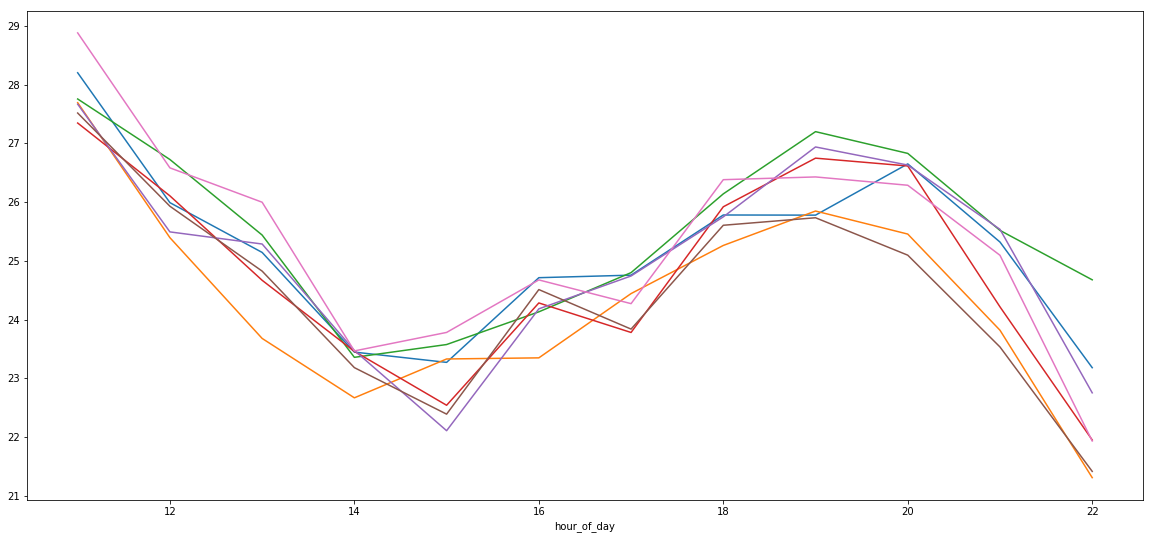

In [152]:
grouped = dataset.groupby('day')
plt.figure(figsize=(20,9))

for name,group in grouped:
    group.groupby('hour_of_day')['kpt'].mean().plot()
    

In [153]:
print(dataset.shape)
print(dataset.count())

(404871, 10)
id                404871
pickup_user_id    404871
total_amount      404871
shipped_at        404627
linked_at         404871
item_name         394055
kpt               404627
hour_of_day       404871
day               404871
nbr_of_items      404871
dtype: int64


As can be seen above, there are missing values in item_name (2% data missing), kpt (<1% missing). Although a process can be set up to impute the data in the missing fields for kpt, imputing item_name can be erroneus. Hence the orders for which these fields were missing were removed

In [154]:
dataset.dropna(subset=['item_name', 'kpt'], how='any', inplace=True)
print(dataset.shape)
print(dataset.count())

(393815, 10)
id                393815
pickup_user_id    393815
total_amount      393815
shipped_at        393815
linked_at         393815
item_name         393815
kpt               393815
hour_of_day       393815
day               393815
nbr_of_items      393815
dtype: int64


Multiple rows which represent different items in a single order were clubbed and item name field was populated with comma separated list of all the items present in the order

In [155]:
dataset.drop(['shipped_at', 'linked_at'], inplace=True, axis=1)
dataset = dataset.groupby(['id','pickup_user_id','total_amount','kpt', 'day', 'hour_of_day','nbr_of_items'])['item_name'].apply(', '.join).reset_index()
print(dataset.shape)
print(dataset.count())
dataset.sample(5)

(184223, 8)
id                184223
pickup_user_id    184223
total_amount      184223
kpt               184223
day               184223
hour_of_day       184223
nbr_of_items      184223
item_name         184223
dtype: int64


,id,pickup_user_id,total_amount,kpt,day,hour_of_day,nbr_of_items,item_name
104576,23652124,11464087,258.48,14.0,Sunday,13,1,chicken biryani
174829,23826292,11452269,220.40,23.0,Tuesday,14,2,"Non Veg Hot Pot Soup Momo, Chocolate Momos [2 ..."
130546,23724569,11451359,975.80,30.0,Saturday,20,2,"Veggie Patty Sub, Veggie Delite Sub"
86931,23599605,11505505,1641.38,9.0,Friday,13,6,"Mutton Zafrani Biryani, Nimbu Pani , Crispy Ve..."
122099,23700412,11529925,126.00,16.0,Thursday,18,2,"Chicken Butter Masala, Tandoori Roti"


## ---------------------------------

## Findings and Future Scenarios

Fields like restaurant id, day of the week, hour of the day, item name can be label-encoded and 1-Hot Encoded and the dataset can be standardized and multiple machine learning regression algorithms can be applied to predict the KPT.

### After spending a good amount of quality time with the data, I observed that, next, a lot of interesting things can be done with the given data. Restaurant id , order id, total amount, day of the order, hour of the day( time of order), number of items in  the order ... these parameters can be further manipulated. Also, we can use NLP to club different items such as yellow dal, dal makhani and dal tadka into one category : Dal . Category of the item will be an important parameter in the regression model which can be applied on this dataset. 

### KPT is a crucial parameter to Zomato as it helps in optimizing the operations, it enhances the process of driver assignment. Based on the data we have, some really good Machine Learning algorithms can be applied and we can predict KPT with a decent accuracy as there are clear patterns in the data in context of order timings, day of the order, number of items in the order etc...